In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import kagglehub

# Download latest version
path = kagglehub.dataset_download("patricklford/global-ev-sales-2010-2024")

print("Path to dataset files:", path)

<ipython-input-1-286813e407b1>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Path to dataset files: /kaggle/input/global-ev-sales-2010-2024


# Initialize the Pandas Data-Frame

In [2]:
dataset_name = path + "/IEA Global EV Data 2024.csv"
pandas_frame = pd.read_csv(dataset_name)

In [3]:
pandas_frame.head(100)

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
1,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
2,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000
...,...,...,...,...,...,...,...,...
95,Austria,Historical,EV stock share,Cars,EV,2010,percent,0.00790
96,Austria,Historical,EV stock share,Cars,EV,2011,percent,0.02200
97,Austria,Historical,EV charging points,EV,Publicly available fast,2011,charging points,0.10000
98,Austria,Historical,EV charging points,EV,Publicly available slow,2011,charging points,0.10000


# Filter the DataFrame for the relevant metric (EV stock share)

Filtering the dataframe for the stock share metric and exclude fields that are not relevant for further calculations.

In [4]:
filtered_frame = pandas_frame[(pandas_frame['parameter'] == 'EV stock share') & (pandas_frame['mode'] == 'Cars')][['region', 'parameter', 'year', 'value']].copy()
filtered_frame = filtered_frame.drop_duplicates(subset=['year', 'region'], keep='last')
filtered_frame = filtered_frame[filtered_frame['year'] <= 2024]

In [5]:
filtered_frame.head(100)

,region,parameter,year,value
0,Australia,EV stock share,2011,0.00039
7,Australia,EV stock share,2012,0.00240
12,Australia,EV stock share,2013,0.00460
19,Australia,EV stock share,2014,0.01400
24,Australia,EV stock share,2015,0.02700
...,...,...,...,...
2389,Denmark,EV stock share,2014,0.13000
2425,Denmark,EV stock share,2015,0.35000
2428,Denmark,EV stock share,2016,0.40000
2469,Denmark,EV stock share,2017,0.42000


# Visualize the EV stock share over the year

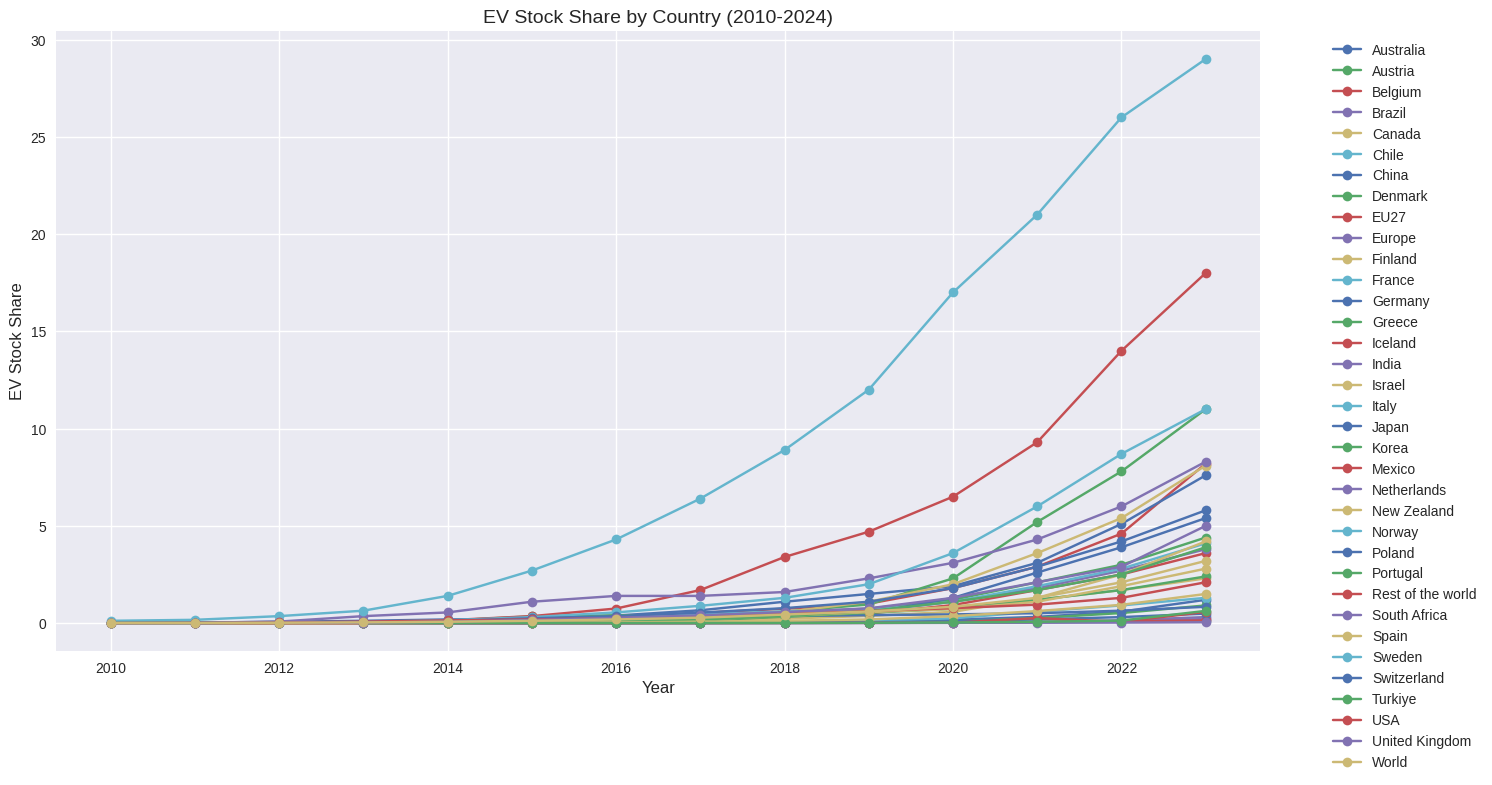

In [6]:
pivot_df = filtered_frame.pivot(index='year', columns='region', values='value')
plt.figure(figsize=(15, 8))
    
for country in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[country], marker='o', label=country)
    
plt.title('EV Stock Share by Country (2010-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('EV Stock Share', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()